In [1]:
# Set the working directory to the parent directory
import sys
sys.path.append('..')
sys.dont_write_bytecode = True

# Import relevant packages
from src.eda import data_info, tsne_scatter, VisualDistr
import pandas as pd
import warnings
import numpy as np
from IPython.display import display
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import joblib

# Config
pd.set_option('display.max_columns', None) # Ensure all columns are displayed
warnings.filterwarnings("ignore")

data = pd.read_feather("../data/unprocessed.feather")
var_info = pd.read_csv("../results/raw_data_description.csv")
vars = [var for var in var_info["var_name"] if var != "y"]
display(var_info)

,var_name,var_type,data_type,missing,mean,median,mode,std_dev,skewness,kurtosis,min,max,num_unique,unique_list
0,age,numerical,int64,0,40.024060,38.000,NaN,10.421250,0.784697,0.791312,17.000,98.000,NaN,NaN
1,job,categorical,object,330,NaN,NaN,admin.,NaN,NaN,NaN,NaN,NaN,11.0,['housemaid' 'services' 'admin.' 'blue-collar'...
2,marital,categorical,object,80,NaN,NaN,married,NaN,NaN,NaN,NaN,NaN,3.0,['married' 'single' 'divorced' 'nan']
3,education,categorical,object,1731,NaN,NaN,university.degree,NaN,NaN,NaN,NaN,NaN,7.0,['basic.4y' 'high.school' 'basic.6y' 'basic.9y...
4,default,binary,object,8597,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,2.0,['no' 'nan' 'yes']
5,housing,binary,object,990,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,2.0,['no' 'yes' 'nan']
6,loan,binary,object,990,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,2.0,['no' 'yes' 'nan']
7,contact,categorical,object,0,NaN,NaN,cellular,NaN,NaN,NaN,NaN,NaN,2.0,['telephone' 'cellular']
8,month,categorical,object,0,NaN,NaN,may,NaN,NaN,NaN,NaN,NaN,10.0,['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'ma...
9,day_of_week,categorical,object,0,NaN,NaN,thu,NaN,NaN,NaN,NaN,NaN,5.0,['mon' 'tue' 'wed' 'thu' 'fri']


## 1. Fill Data

In [2]:
def fill_data(var, data, var_info, fill_tp=None, fill_val=0):
    if fill_tp:
        fill_val = var_info[var_info["var_name"]==var][fill_tp].tolist()[0]
    return data[var].fillna(fill_val)

In [3]:
filled_data = data.copy()

# Fill with mean
for var in ["emp_var_rate", "cons_price_idx", "cons_conf_idx", "euribor3m", "nr_employed"]:
    filled_data[var] = fill_data(var, data, var_info, fill_tp="mean")
# Fill with median
for var in ["age", "campaign"]:
    filled_data[var] = fill_data(var, data, var_info, fill_tp="median")
# Fill with mode
for var in ["marital", "contact", "month", "day_of_week", "poutcome"]:
    filled_data[var] = fill_data(var, data, var_info, fill_tp="mode")
# Fill with "unknown"
for var in ["job", "education", "default", "housing", "loan"]:
    filled_data[var] = fill_data(var, data, var_info, fill_val="unknown")
# Fill with specific values
filled_data["duration"] = fill_data("duration", data, var_info, fill_val=0)
filled_data["pdays"] = fill_data("pdays", data, var_info, fill_val=-1)
filled_data["previous"] = fill_data("previous", data, var_info, fill_val=0)

# Show new variable information
var_info = data_info(filled_data)
display(var_info)

,var_name,var_type,data_type,missing,mean,median,mode,std_dev,skewness,kurtosis,min,max,num_unique,unique_list
0,age,numerical,int64,0,40.024060,38.000,NaN,10.421250,0.784697,0.791312,17.000,98.000,NaN,NaN
1,job,categorical,object,0,NaN,NaN,admin.,NaN,NaN,NaN,NaN,NaN,12.0,"[housemaid, services, admin., blue-collar, tec..."
2,marital,categorical,object,0,NaN,NaN,married,NaN,NaN,NaN,NaN,NaN,3.0,"[married, single, divorced]"
3,education,categorical,object,0,NaN,NaN,university.degree,NaN,NaN,NaN,NaN,NaN,8.0,"[basic.4y, high.school, basic.6y, basic.9y, pr..."
4,default,categorical,object,0,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,3.0,"[no, unknown, yes]"
5,housing,categorical,object,0,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,3.0,"[no, yes, unknown]"
6,loan,categorical,object,0,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,3.0,"[no, yes, unknown]"
7,contact,categorical,object,0,NaN,NaN,cellular,NaN,NaN,NaN,NaN,NaN,2.0,"[telephone, cellular]"
8,month,categorical,object,0,NaN,NaN,may,NaN,NaN,NaN,NaN,NaN,10.0,"[may, jun, jul, aug, oct, nov, dec, mar, apr, ..."
9,day_of_week,categorical,object,0,NaN,NaN,thu,NaN,NaN,NaN,NaN,NaN,5.0,"[mon, tue, wed, thu, fri]"


## 2. Pre-Scale Data

In [4]:
prescaled_data = filled_data.copy()

# Pre-scale with bucketing or log transform
def bucket_pdays(x):
    if x < 0:
        return "never"
    elif x <= 5:
        return "recent"
    elif x <= 30:
        return "intermediate"
    else:
        return "long_ago"
prescaled_data["pdays"] = filled_data["pdays"].apply(lambda x: bucket_pdays(x))
prescaled_data["duration"] = np.log10(filled_data["duration"] + 0.00001)
prescaled_data["campaign"] = np.log10(filled_data["campaign"] + 0.00001)
prescaled_data["previous"] = np.log10(filled_data["previous"] + 0.00001)

# Show new variable information
var_info = data_info(prescaled_data)
display(var_info)

,var_name,var_type,data_type,missing,mean,median,mode,std_dev,skewness,kurtosis,min,max,num_unique,unique_list
0,age,numerical,int64,0,40.024060,38.000000,NaN,10.421250,0.784697,0.791312,17.000000,98.000000,NaN,NaN
1,job,categorical,object,0,NaN,NaN,admin.,NaN,NaN,NaN,NaN,NaN,12.0,"[housemaid, services, admin., blue-collar, tec..."
2,marital,categorical,object,0,NaN,NaN,married,NaN,NaN,NaN,NaN,NaN,3.0,"[married, single, divorced]"
3,education,categorical,object,0,NaN,NaN,university.degree,NaN,NaN,NaN,NaN,NaN,8.0,"[basic.4y, high.school, basic.6y, basic.9y, pr..."
4,default,categorical,object,0,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,3.0,"[no, unknown, yes]"
5,housing,categorical,object,0,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,3.0,"[no, yes, unknown]"
6,loan,categorical,object,0,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,3.0,"[no, yes, unknown]"
7,contact,categorical,object,0,NaN,NaN,cellular,NaN,NaN,NaN,NaN,NaN,2.0,"[telephone, cellular]"
8,month,categorical,object,0,NaN,NaN,may,NaN,NaN,NaN,NaN,NaN,10.0,"[may, jun, jul, aug, oct, nov, dec, mar, apr, ..."
9,day_of_week,categorical,object,0,NaN,NaN,thu,NaN,NaN,NaN,NaN,NaN,5.0,"[mon, tue, wed, thu, fri]"


## 3. Encode Data

In [5]:
encoded_data = prescaled_data.copy()

# Binary data
for var in var_info[var_info["var_type"]=="binary"]["var_name"]:
    encoded_data[var] = prescaled_data[var].apply(lambda x: 1 if x=="yes" else 0)
# Categorical data
encoded_data = pd.get_dummies(encoded_data, dtype=int, columns=var_info[var_info["var_type"]=="categorical"]["var_name"].tolist())

## 4. t-SNE Scatter Plot

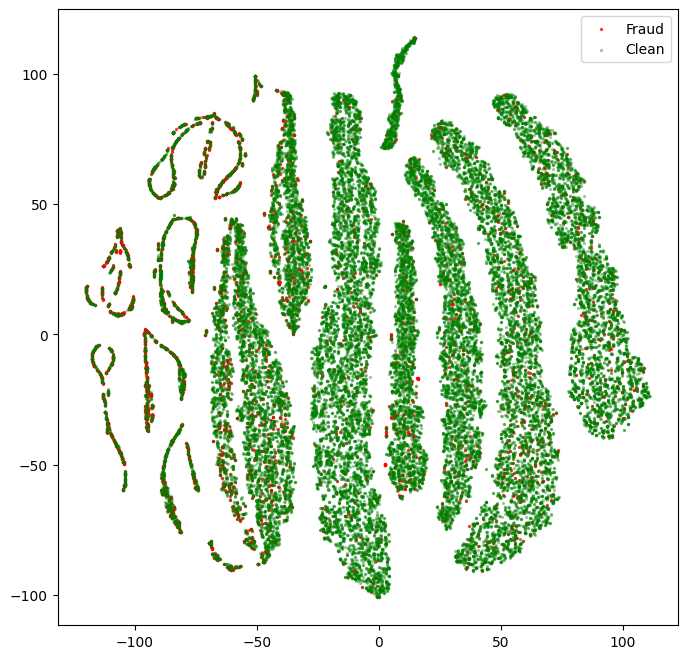

In [6]:
# Isolate features from labels 
features, labels = encoded_data.drop('y', axis=1).values, encoded_data.y.values

# Create the scatter plot
tsne = tsne_scatter(features, labels, dimensions=2)
tsne.show()

## 5. Split Data

In [ ]:
# Generate normal dataset and shuffle
normal_data = encoded_data[encoded_data.y == 0].sample(frac=1).reset_index(drop=True)

# Generate anomaly dataset
anomaly_data = encoded_data[encoded_data.y == 1]

# Training set: exlusively normal observations (60%)
train_size = int(len(normal_data)*0.6)
X_train = normal_data.iloc[:train_size].drop('y', axis=1)

# Train-validate split
X_train, X_train_validate = train_test_split(X_train, test_size=0.2, random_state=42)

# Testing set: the remaining normal + all the anomaly 
X_test = pd.concat([normal_data.iloc[train_size:], anomaly_data]).sample(frac=1, random_state=42)
X_validate, X_test = train_test_split(X_test, test_size=0.5, random_state=42)
print("Proportions of y in validation set:")
print(X_validate.y.value_counts())
print("Proportions of y in test set:")
print(X_test.y.value_counts())

# Isolating the labels from the features
X_validate, y_validate = X_validate.drop('y', axis=1), X_validate[["y"]]
X_test, y_test = X_test.drop('y', axis=1), X_test[["y"]]

print(f"""Size of the datasets:
    Training: {X_train.shape}
    Validate: {X_validate.shape}
    Test: {X_test.shape}""")

Proportions of y in validation set:
y
0    7245
1    2385
Name: count, dtype: int64
Proportions of y in test set:
y
0    7375
1    2255
Name: count, dtype: int64
Size of the datasets:
    Training: (17542, 64)
    Validate: (9630, 64)
    Test: (9630, 64)


## 6. Scale Data

In [8]:
class ScaleData:

    def __init__(self, var_info):
        # Get list of numerical variables
        self.num_vars = var_info[var_info['var_type']=="numerical"]['var_name'].tolist()

    def scale_fit(self, train_data):
        # Create the pipeline to scale data: normalize then scale to [0,1]
        pipeline = Pipeline([('normalizer', Normalizer()),
                        ('scaler', MinMaxScaler())])
        pipeline.fit(train_data[self.num_vars])
        # Save the pipeline
        joblib.dump(pipeline, "../data/scalers")
        
        return pipeline

    def scale_transform(self, data, pipeline):
        # Isolate numerical and categorical data
        num_data = data[self.num_vars]
        cat_data = data[[col for col in data.columns if col not in self.num_vars]].reset_index(drop=True)
        # Scale the numerical data
        scaled_data = pd.DataFrame(pipeline.transform(num_data), columns=num_data.columns)
        # Concat the numerical and categorical data
        return pd.concat([scaled_data, cat_data], axis=1)

In [9]:
sd = ScaleData(var_info)
pipeline = sd.scale_fit(X_train)
X_train_scaled = sd.scale_transform(X_train, pipeline)
X_train_validate_scaled = sd.scale_transform(X_train_validate, pipeline)
X_validate_scaled = sd.scale_transform(X_validate, pipeline)
X_test_scaled = sd.scale_transform(X_test, pipeline)

## 7. Visualize Preprocessed Data

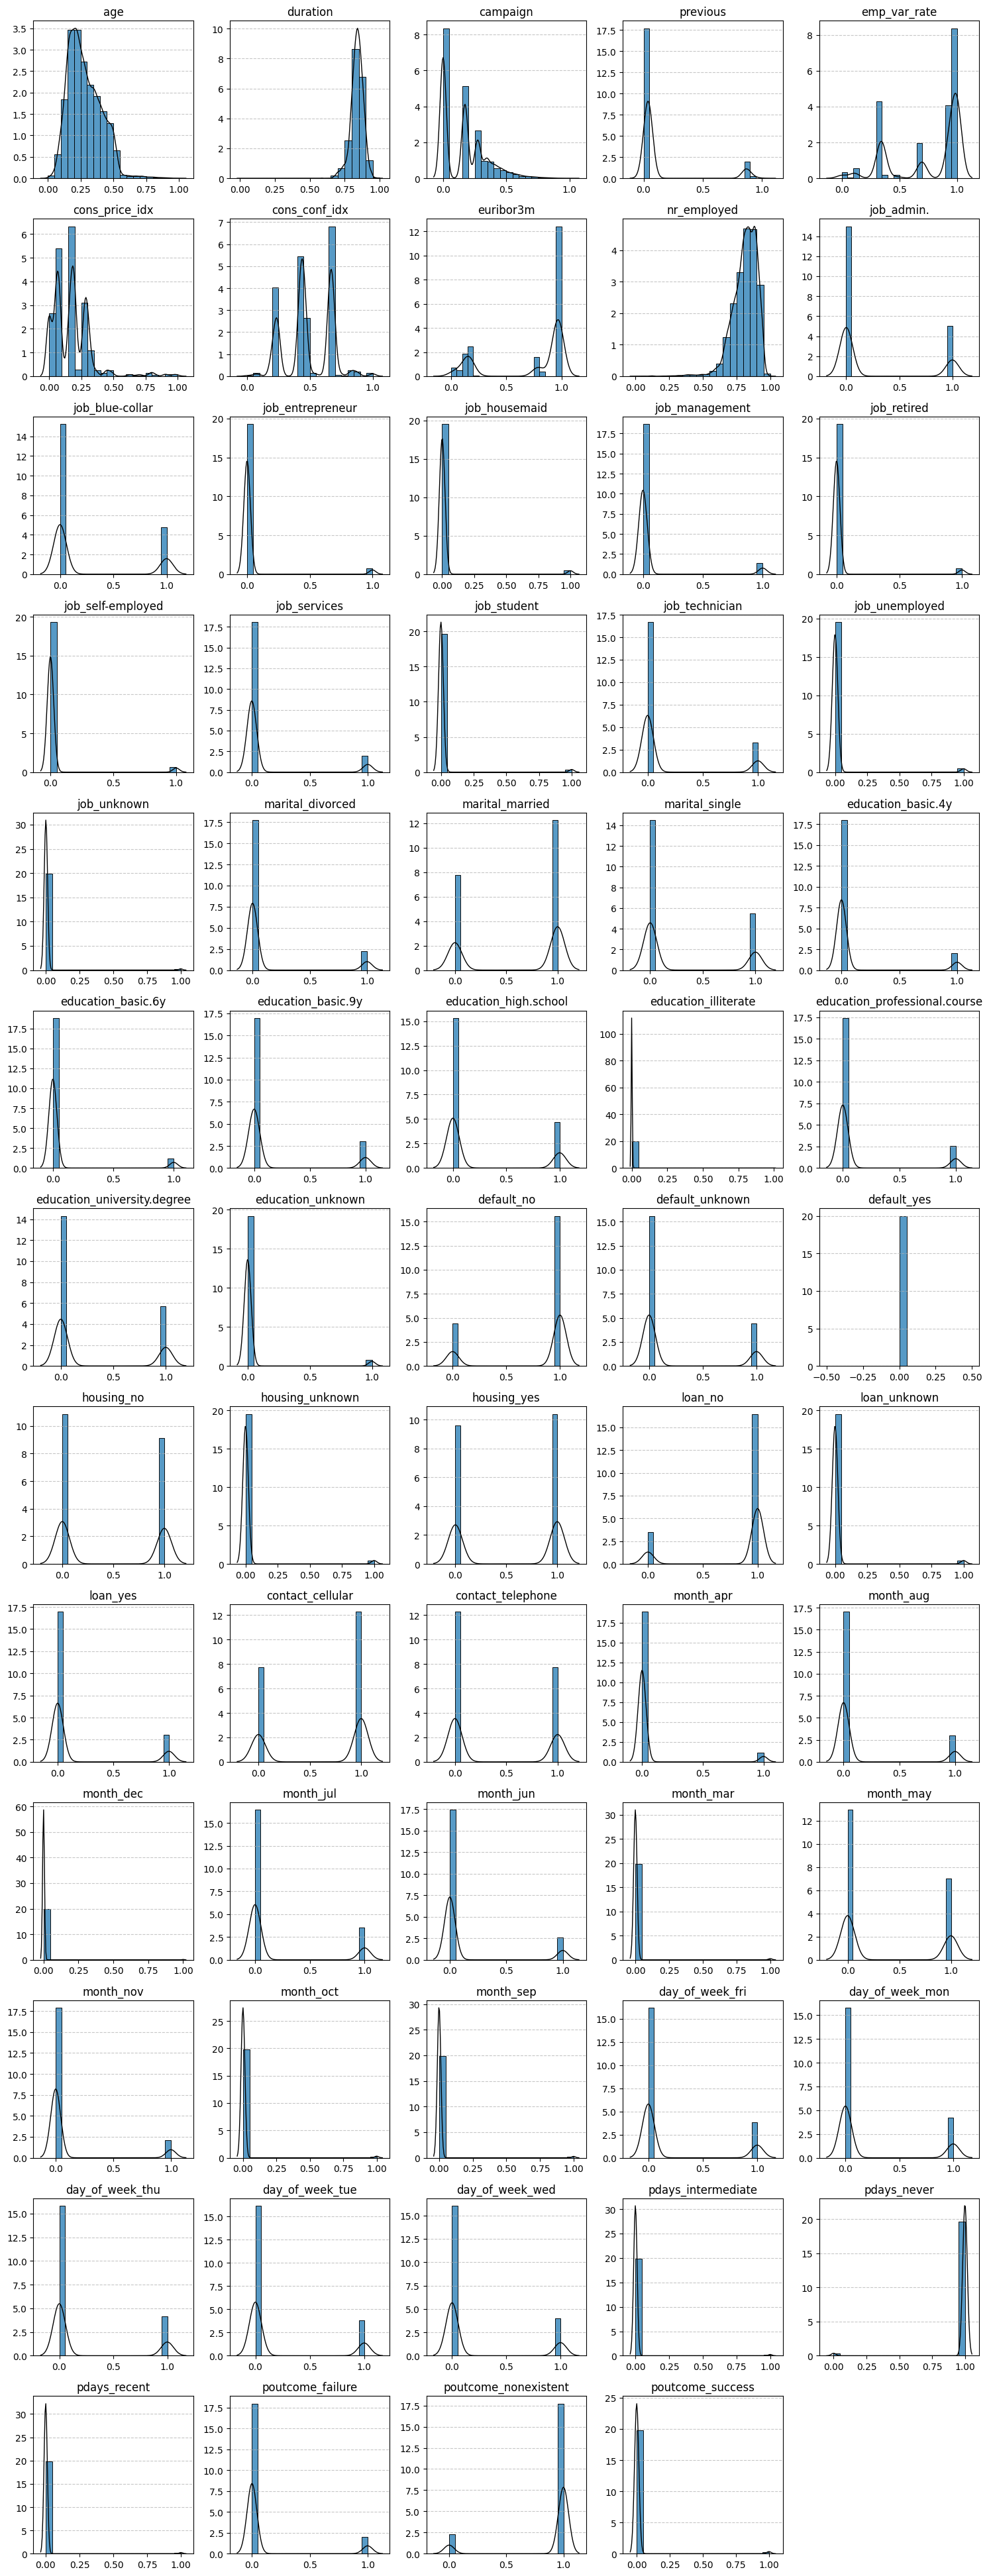

In [10]:
# Show new variable information
var_info = data_info(encoded_data)

# Isolate numerical variables
num_vars = var_info[(var_info['var_type']=='numerical')&(var_info['var_name']!='y')]['var_name']
vd = VisualDistr(X_train_scaled, numerical_variables=num_vars)

# Plot the distributions of numerical variables
plt_num_distr = vd.plot_numerical_distributions(bins=20)
plt_num_distr.savefig("../figures/train_num_distr.png")
plt_num_distr.show()

## 8. Save data

In [11]:
X_train_scaled.to_feather("../data/X_train.feather")
X_train_validate_scaled.to_feather("../data/X_train_validate.feather")
X_validate_scaled.to_feather("../data/X_validate.feather")
X_test_scaled.to_feather("../data/X_test.feather")

y_validate.to_feather("../data/y_validate.feather")
y_test.to_feather("../data/y_test.feather")